# From
http://tomaugspurger.github.io/modern-5-tidy.html

In [1]:
%matplotlib inline

import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

if int(os.environ.get("MODERN_PANDAS_EPUB", 0)):
    import prep # noqa

pd.options.display.max_rows = 10
sns.set(style='ticks', context='talk')

## Use read_html to extract a table contained within a web page

In [2]:
fp = 'nba.csv'

tables = pd.read_html("http://www.basketball-reference.com/leagues/NBA_2016_games.html")
games = tables[0]
games.to_csv(fp)

games.head()

,Date,Start (ET),Visitor/Neutral,PTS,Home/Neutral,PTS.1,,.1,Notes
0,"Tue, Oct 27, 2015",8:00 pm,Detroit Pistons,106,Atlanta Hawks,94,Box Score,NaN,NaN
1,"Tue, Oct 27, 2015",8:00 pm,Cleveland Cavaliers,95,Chicago Bulls,97,Box Score,NaN,NaN
2,"Tue, Oct 27, 2015",10:30 pm,New Orleans Pelicans,95,Golden State Warriors,111,Box Score,NaN,NaN
3,"Wed, Oct 28, 2015",7:30 pm,Philadelphia 76ers,95,Boston Celtics,112,Box Score,NaN,NaN
4,"Wed, Oct 28, 2015",7:30 pm,Chicago Bulls,115,Brooklyn Nets,100,Box Score,NaN,NaN


## Clean up the table:
### Rename columns
### Transform data format
###  Set index to (game_id, date) pair

In [3]:
column_names = {'Date': 'date', 'Start (ET)': 'start',
                'Unamed: 2': 'box', 'Visitor/Neutral': 'away_team', 
                'PTS': 'away_points', 'Home/Neutral': 'home_team',
                'PTS.1': 'home_points', 'Unamed: 7': 'n_ot'}

games = (games.rename(columns=column_names)
    .dropna(thresh=4)
    [['date', 'away_team', 'away_points', 'home_team', 'home_points']]
    .assign(date=lambda x: pd.to_datetime(x['date'], format='%a, %b %d, %Y'))
    .set_index('date', append=True)
    .rename_axis(["game_id", "date"])
    .sort_index())
games.head()

,,away_team,away_points,home_team,home_points
game_id,date,,,,
0,2015-10-27,Detroit Pistons,106,Atlanta Hawks,94
1,2015-10-27,Cleveland Cavaliers,95,Chicago Bulls,97
2,2015-10-27,New Orleans Pelicans,95,Golden State Warriors,111
3,2015-10-28,Philadelphia 76ers,95,Boston Celtics,112
4,2015-10-28,Chicago Bulls,115,Brooklyn Nets,100


In [4]:
games.shape

(38, 4)

# games is "game oriented"
### A "game" is identified triple:
## (date, away_team, home_team) is unique key

## Wide to skinny

### Create "tidy" which is "team oriented"
#### (date, team) is unique key
### Once in this shape (skinny, rather than wide) we can easily add a "rest" column
#### Group by "team", then take within-group difference of "date" to get days between games

###   The values in the  new column "variable" are the original column names "away_team" and "home_team"; the value in the original column is stored in "team"



In [62]:
tidy = pd.melt(games.reset_index(),
               id_vars=['game_id', 'date'], value_vars=['away_team', 'home_team'],
               value_name='team')
tidy.head()

,game_id,date,variable,team
0,0,2015-10-27,away_team,Detroit Pistons
1,1,2015-10-27,away_team,Cleveland Cavaliers
2,2,2015-10-27,away_team,New Orleans Pelicans
3,3,2015-10-28,away_team,Philadelphia 76ers
4,4,2015-10-28,away_team,Chicago Bulls


## Note that the result has twice the number of rows as the original
###  since we are taking two columns and replacing them by one

In [63]:
tidy['variable'].unique()

array(['away_team', 'home_team'], dtype=object)

In [6]:
tidy.shape

(76, 4)

## Note what happens if we DIDN'T include the id_vars arg. in melt:

In [64]:
pd.melt(games.reset_index(),
               value_vars=['away_team', 'home_team'],
               value_name='team')

,variable,team
0,away_team,Detroit Pistons
1,away_team,Cleveland Cavaliers
2,away_team,New Orleans Pelicans
3,away_team,Philadelphia 76ers
4,away_team,Chicago Bulls
...,...,...
71,home_team,Los Angeles Clippers
72,home_team,Memphis Grizzlies
73,home_team,New Orleans Pelicans
74,home_team,Portland Trail Blazers


In [7]:
# For each team... get number of days between games
tidy.groupby('team')['date'].diff().dt.days - 1

0     NaN
1     NaN
2     NaN
3     NaN
4     NaN
     ... 
71    1.0
72    2.0
73    2.0
74    2.0
75    0.0
Name: date, dtype: float64

In [69]:
tidy['rest'] = tidy.sort_values('date').groupby('team').date.diff().dt.days - 1
tidy.dropna().head()

,game_id,date,variable,team,rest
4,4,2015-10-28,away_team,Chicago Bulls,0.0
8,8,2015-10-28,away_team,Cleveland Cavaliers,0.0
14,14,2015-10-28,away_team,New Orleans Pelicans,0.0
17,17,2015-10-29,away_team,Memphis Grizzlies,0.0
18,18,2015-10-29,away_team,Dallas Mavericks,0.0


## Turn back into wide table, now that we've added the "rest" column

In [9]:
by_game = (pd.pivot_table(tidy, values='rest',
                          index=['game_id', 'date'],
                          columns='variable')
             .rename(columns={'away_team': 'away_rest',
                              'home_team': 'home_rest'}))
by_game.head()

,variable,away_rest,home_rest
game_id,date,,
0,2015-10-27,NaN,NaN
1,2015-10-27,NaN,NaN
2,2015-10-27,NaN,NaN
3,2015-10-28,NaN,NaN
4,2015-10-28,0.0,NaN


In [10]:
by_game.shape

(38, 2)

## Now that by_game is wide, we can glue it to the games table
### Recall that "concat" does a join (default is outer join)
### Since both by_game and games have same number of rows, indexed by (game_id, date) the type of join doesn't matter

In [11]:
df = pd.concat([games, by_game], axis=1)
df.dropna().head()

,,away_team,away_points,home_team,home_points,away_rest,home_rest
game_id,date,,,,,,
17,2015-10-29,Memphis Grizzlies,112,Indiana Pacers,103,0.0,0.0
18,2015-10-29,Dallas Mavericks,88,Los Angeles Clippers,104,0.0,0.0
19,2015-10-29,Atlanta Hawks,112,New York Knicks,101,1.0,0.0
20,2015-10-30,Charlotte Hornets,94,Atlanta Hawks,97,1.0,0.0
21,2015-10-30,Toronto Raptors,113,Boston Celtics,103,1.0,1.0


# "tidy" is team oriented.
## Do some team-oriented graphing
### Plot "variable" (x) versus "rest" (y); grouped by "team" (hue)

In [12]:
tidy['variable'].unique()

array(['away_team', 'home_team'], dtype=object)

In [13]:
tidy["team"].unique().shape

(30,)

In [14]:
tidy.shape

(76, 5)

In [15]:
tidy.dropna().shape

(46, 5)

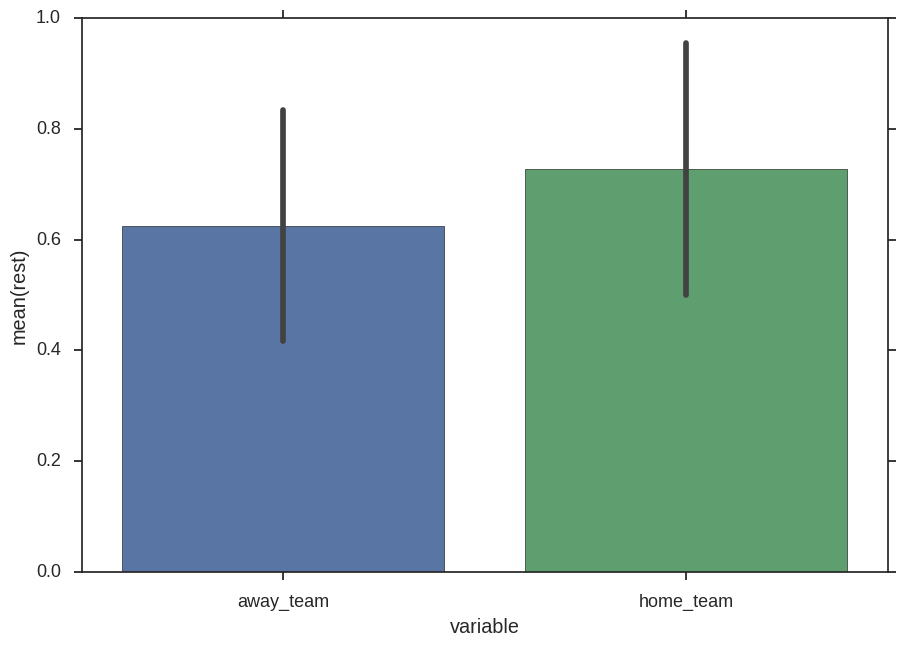

In [17]:
sns.barplot(tidy['variable'], tidy['rest'])

In [39]:
pd.Series(tidy["team"]).isin(["Detroit Pistons"])

0      True
1     False
2     False
3     False
4     False
      ...  
71    False
72    False
73    False
74    False
75    False
Name: team, dtype: bool

In [43]:
tidyOneTeam = tidy[ pd.Series(tidy['team']).isin(["Boston Celtics", "Detroit Pistons"]) ]
tidyOneTeam.sort_values('team')

,game_id,date,variable,team,rest
41,3,2015-10-28,home_team,Boston Celtics,NaN
59,21,2015-10-30,home_team,Boston Celtics,1.0
0,0,2015-10-27,away_team,Detroit Pistons,NaN
43,5,2015-10-28,home_team,Detroit Pistons,0.0
62,24,2015-10-30,home_team,Detroit Pistons,1.0


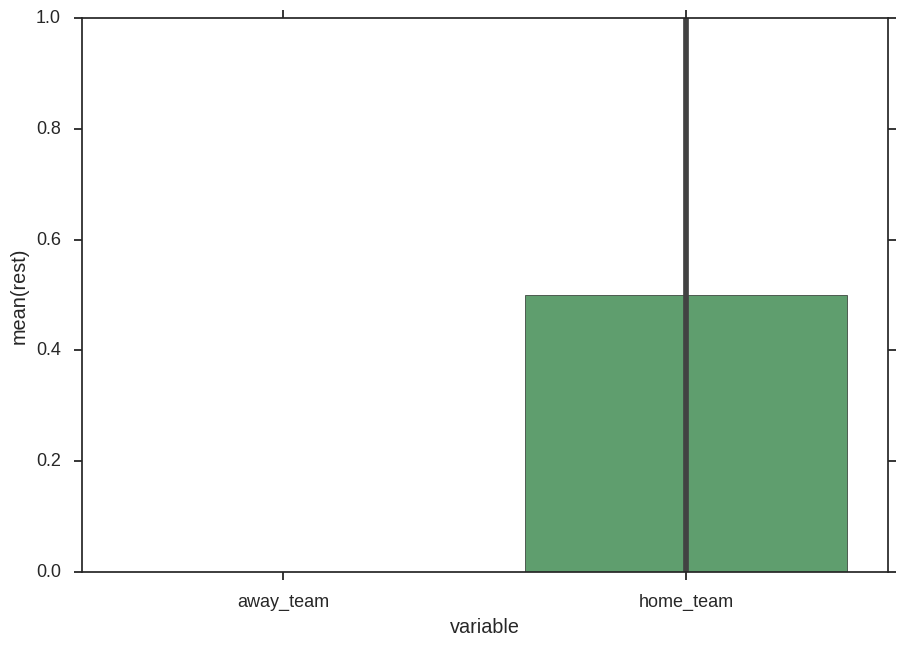

In [19]:
sns.barplot(tidyOneTeam['variable'], tidyOneTeam['rest'])

## FacetGrid below doesn't look like what appears on web page, nor how
### sns.barplot works above (x-axis is "variable"): should be two bars per plot 
#### one for variable=home_team and one for variable=away_team

## Suspect problem is sns.FacetGrid
#### Get same symptom even if use tidyOneTeam as table
#### Maybe it's because most teams DON'T have BOTH home and away games

###  Note the 0 days of rest for some teams
### Also, "rest" is NaN for the first game of season since there is no prior date, but this doesn't seem to be the issue

In [106]:
tidy.sort_values(['date', 'variable'])

,game_id,date,variable,team,rest
0,0,2015-10-27,away_team,Detroit Pistons,NaN
1,1,2015-10-27,away_team,Cleveland Cavaliers,NaN
2,2,2015-10-27,away_team,New Orleans Pelicans,NaN
38,0,2015-10-27,home_team,Atlanta Hawks,NaN
39,1,2015-10-27,home_team,Chicago Bulls,NaN
...,...,...,...,...,...
71,33,2015-10-31,home_team,Los Angeles Clippers,1.0
72,34,2015-10-31,home_team,Memphis Grizzlies,1.0
73,35,2015-10-31,home_team,New Orleans Pelicans,2.0
74,36,2015-10-31,home_team,Portland Trail Blazers,0.0


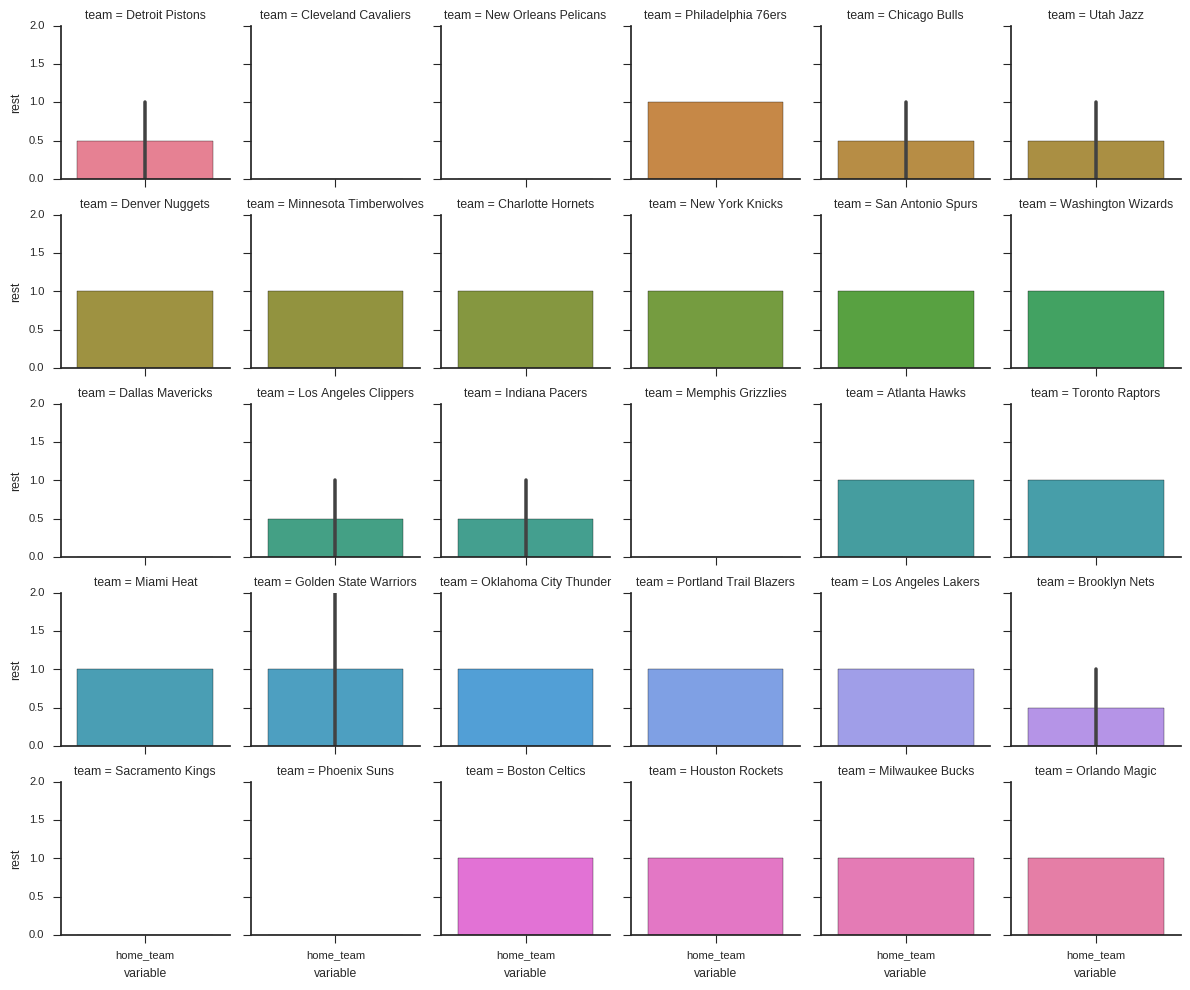

In [141]:
sns.set(style='ticks', context='paper')
g = sns.FacetGrid(tidy, col="team", col_wrap=6, hue="team", size=2)
g.map(sns.barplot, 'variable', 'rest');

In [71]:
tidy[ tidy['team'] == 'Sacramento Kings']

,game_id,date,variable,team,rest
33,33,2015-10-31,away_team,Sacramento Kings,0.0
53,15,2015-10-28,home_team,Sacramento Kings,NaN
68,30,2015-10-30,home_team,Sacramento Kings,1.0


In [22]:
df['home_win'] = df['home_points'] > df['away_points']
df['rest_spread'] = df['home_rest'] - df['away_rest']
df.dropna().head()

,,away_team,away_points,home_team,home_points,away_rest,home_rest,home_win,rest_spread
game_id,date,,,,,,,,
17,2015-10-29,Memphis Grizzlies,112,Indiana Pacers,103,0.0,0.0,False,0.0
18,2015-10-29,Dallas Mavericks,88,Los Angeles Clippers,104,0.0,0.0,True,0.0
19,2015-10-29,Atlanta Hawks,112,New York Knicks,101,1.0,0.0,False,-1.0
20,2015-10-30,Charlotte Hornets,94,Atlanta Hawks,97,1.0,0.0,True,-1.0
21,2015-10-30,Toronto Raptors,113,Boston Celtics,103,1.0,1.0,False,0.0


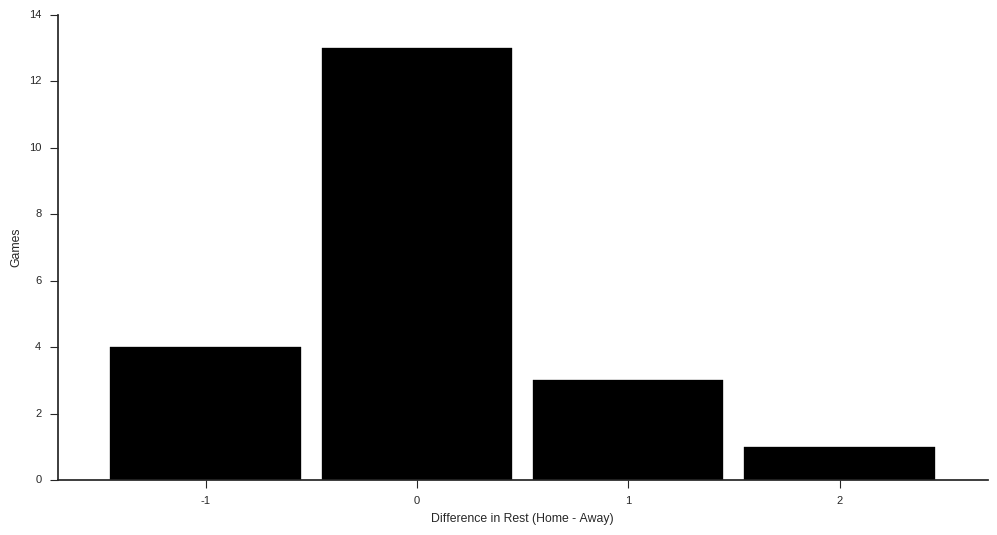

In [24]:
delta = (by_game.home_rest - by_game.away_rest).dropna().astype(int)
ax = (delta.value_counts()
    .reindex(np.arange(delta.min(), delta.max() + 1), fill_value=0)
    .sort_index()
    .plot(kind='bar', color='k', width=.9, rot=0, figsize=(12, 6))
)
sns.despine()
ax.set(xlabel='Difference in Rest (Home - Away)', ylabel='Games')

## My attempt to replicate above, using df

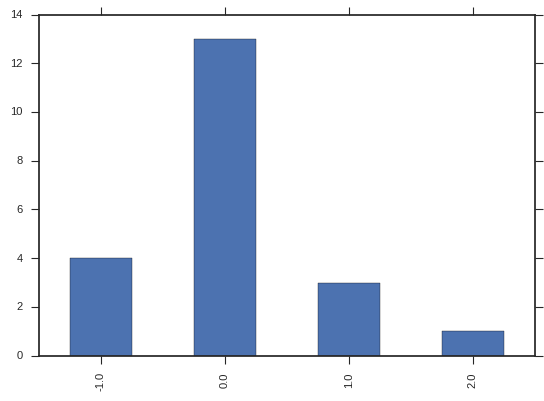

In [86]:

(df['rest_spread']
.value_counts()   # count of each rest_spread
.reindex(np.arange( df['rest_spread'].min(), df['rest_spread'].max() +1) ) # re -order the row
.plot(kind='bar')  # plot the dataframe
)
   

## sns.barplot instead of pandas.plot(kind='bar')

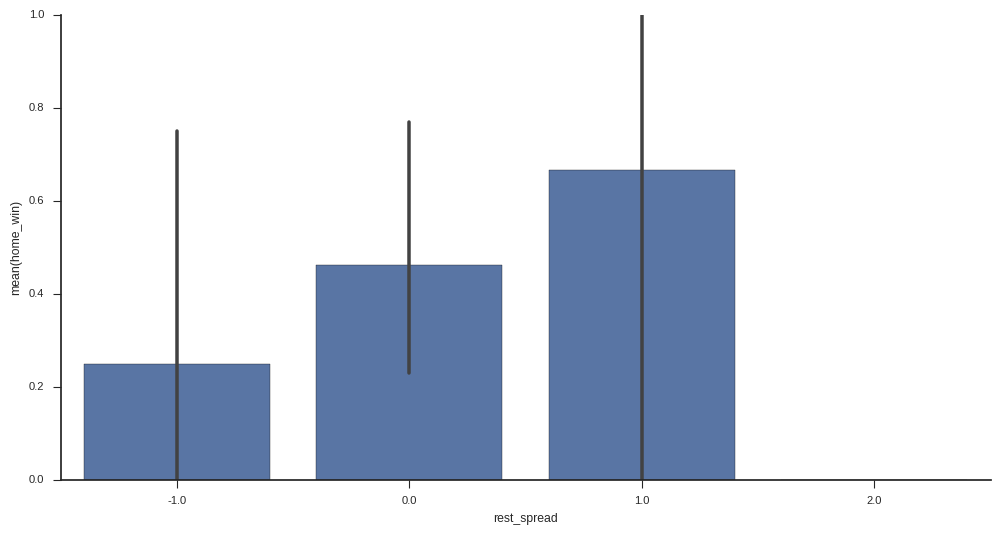

In [90]:
fig, ax = plt.subplots(figsize=(12, 6))
sns.barplot(x='rest_spread', y='home_win', data=df.query('-3 <= rest_spread <= 3'),
            color='#4c72b0', ax=ax)
sns.despine()

## Stack/Unstack (MultiIndex version of Wide to Thin, Thin to Wide)

In [107]:
index = pd.MultiIndex.from_tuples([('one', 'a'), ('one', 'b'),
...                                    ('two', 'a'), ('two', 'b')])
>>> s = pd.Series(np.arange(1.0, 5.0), index=index)
>>> s

one  a    1.0
     b    2.0
two  a    3.0
     b    4.0
dtype: float64

In [114]:
s.unstack(level=0).loc['a', 'two']

3.0

In [112]:
s.loc[ 'one']

a    1.0
b    2.0
dtype: float64

In [105]:
tidy.sort_values(['date', 'variable'])

,game_id,date,variable,team,rest
0,0,2015-10-27,away_team,Detroit Pistons,NaN
1,1,2015-10-27,away_team,Cleveland Cavaliers,NaN
2,2,2015-10-27,away_team,New Orleans Pelicans,NaN
38,0,2015-10-27,home_team,Atlanta Hawks,NaN
39,1,2015-10-27,home_team,Chicago Bulls,NaN
...,...,...,...,...,...
71,33,2015-10-31,home_team,Los Angeles Clippers,1.0
72,34,2015-10-31,home_team,Memphis Grizzlies,1.0
73,35,2015-10-31,home_team,New Orleans Pelicans,2.0
74,36,2015-10-31,home_team,Portland Trail Blazers,0.0


In [26]:
rest = (tidy.groupby(['date', 'variable'])
            .rest.mean()
            .dropna())
rest.head()

date        variable 
2015-10-28  away_team    0.000000
            home_team    0.000000
2015-10-29  away_team    0.333333
            home_team    0.000000
2015-10-30  away_team    1.083333
Name: rest, dtype: float64

## Thin to wide

## 'away_team' is part of MultiIndex of rest

In [132]:
idx = pd.IndexSlice
rest.loc[ idx[:,'away_team'] ]

date
2015-10-28    0.000000
2015-10-29    0.333333
2015-10-30    1.083333
2015-10-31    0.166667
Name: rest, dtype: float64

In [124]:
rest.loc[:,'away_team']

date
2015-10-28    0.000000
2015-10-29    0.333333
2015-10-30    1.083333
2015-10-31    0.166667
Name: rest, dtype: float64

In [117]:
rest.unstack().head()

variable,away_team,home_team
date,,
2015-10-28,0.000000,0.000000
2015-10-29,0.333333,0.000000
2015-10-30,1.083333,0.916667
2015-10-31,0.166667,0.833333


## 'away_team' is a column of rest.unstack()

In [122]:
(rest.unstack()
    .loc[:,'away_team']
 )

date
2015-10-28    0.000000
2015-10-29    0.333333
2015-10-30    1.083333
2015-10-31    0.166667
Name: away_team, dtype: float64

## Wide to thin

In [29]:
rest.unstack().stack()

date        variable 
2015-10-28  away_team    0.000000
            home_team    0.000000
2015-10-29  away_team    0.333333
            home_team    0.000000
2015-10-30  away_team    1.083333
            home_team    0.916667
2015-10-31  away_team    0.166667
            home_team    0.833333
dtype: float64

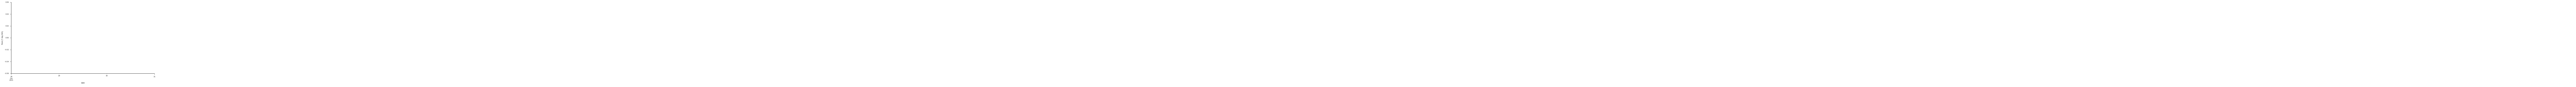

In [31]:
with sns.color_palette() as pal:
    b, g = pal.as_hex()[:2]

ax=(rest.unstack()
        .query('away_team < 7')
        .rolling(7)
        .mean()
        .plot(figsize=(12, 6), linewidth=3, legend=False))
ax.set(ylabel='Rest (7 day MA)')
ax.annotate("Home", (rest.index[-1][0], 1.02), color=g, size=14)
ax.annotate("Away", (rest.index[-1][0], 0.82), color=b, size=14)
sns.despine()

## Mini project

In [45]:
df['home_win'] = df.home_points > df.away_points

In [48]:
df.columns

Index(['away_team', 'away_points', 'home_team', 'home_points', 'away_rest',
       'home_rest', 'home_win', 'rest_spread'],
      dtype='object')

In [46]:
df.head()

,,away_team,away_points,home_team,home_points,away_rest,home_rest,home_win,rest_spread
game_id,date,,,,,,,,
0,2015-10-27,Detroit Pistons,106,Atlanta Hawks,94,NaN,NaN,False,NaN
1,2015-10-27,Cleveland Cavaliers,95,Chicago Bulls,97,NaN,NaN,True,NaN
2,2015-10-27,New Orleans Pelicans,95,Golden State Warriors,111,NaN,NaN,True,NaN
3,2015-10-28,Philadelphia 76ers,95,Boston Celtics,112,NaN,NaN,True,NaN
4,2015-10-28,Chicago Bulls,115,Brooklyn Nets,100,0.0,NaN,False,NaN


In [133]:
(
    pd.melt(df.reset_index(),
            id_vars=['game_id', 'date', 'home_win'],
            value_name='team', var_name='is_home',
            value_vars=['home_team', 'away_team'])
   .assign(win=lambda x: x.home_win == (x.is_home == 'home_team'))
    )

,game_id,date,home_win,is_home,team,win
0,0,2015-10-27,False,home_team,Atlanta Hawks,False
1,1,2015-10-27,True,home_team,Chicago Bulls,True
2,2,2015-10-27,True,home_team,Golden State Warriors,True
3,3,2015-10-28,True,home_team,Boston Celtics,True
4,4,2015-10-28,False,home_team,Brooklyn Nets,False
...,...,...,...,...,...,...
71,33,2015-10-31,True,away_team,Sacramento Kings,False
72,34,2015-10-31,True,away_team,Brooklyn Nets,False
73,35,2015-10-31,False,away_team,Golden State Warriors,True
74,36,2015-10-31,False,away_team,Phoenix Suns,True


In [135]:
(
    pd.melt(df.reset_index(),
            id_vars=['game_id', 'date', 'home_win'],
            value_name='team', var_name='is_home',
            value_vars=['home_team', 'away_team'])
   .assign(win=lambda x: x.home_win == (x.is_home == 'home_team'))
   .groupby(['team', 'is_home'])
   .win
    .agg(['sum', 'count', 'mean'])
    )

sum  count      mean
team               is_home                        
Atlanta Hawks      away_team  1.0      1  1.000000
                   home_team  1.0      2  0.500000
Boston Celtics     home_team  1.0      2  0.500000
Brooklyn Nets      away_team  0.0      2  0.000000
                   home_team  0.0      1  0.000000
...                           ...    ...       ...
Toronto Raptors    away_team  1.0      1  1.000000
                   home_team  1.0      1  1.000000
Utah Jazz          away_team  2.0      3  0.666667
Washington Wizards away_team  2.0      2  1.000000
                   home_team  0.0      1  0.000000

[52 rows x 3 columns]

In [47]:
wins = (
    pd.melt(df.reset_index(),
            id_vars=['game_id', 'date', 'home_win'],
            value_name='team', var_name='is_home',
            value_vars=['home_team', 'away_team'])
   .assign(win=lambda x: x.home_win == (x.is_home == 'home_team'))
   .groupby(['team', 'is_home'])
   .win
   .agg(['sum', 'count', 'mean'])
   .rename(columns=dict(sum='n_wins',
                        count='n_games',
                        mean='win_pct'))
)
wins.head()

n_wins  n_games  win_pct
team           is_home                            
Atlanta Hawks  away_team     1.0        1      1.0
               home_team     1.0        2      0.5
Boston Celtics home_team     1.0        2      0.5
Brooklyn Nets  away_team     0.0        2      0.0
               home_team     0.0        1      0.0

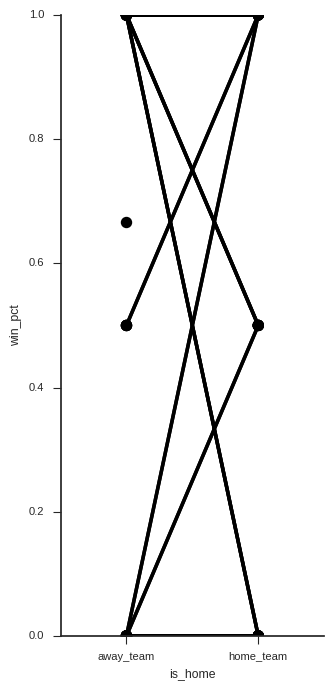

In [49]:
g = sns.FacetGrid(wins.reset_index(), hue='team', size=7, aspect=.5, palette=['k'])
g.map(sns.pointplot, 'is_home', 'win_pct').set(ylim=(0, 1));


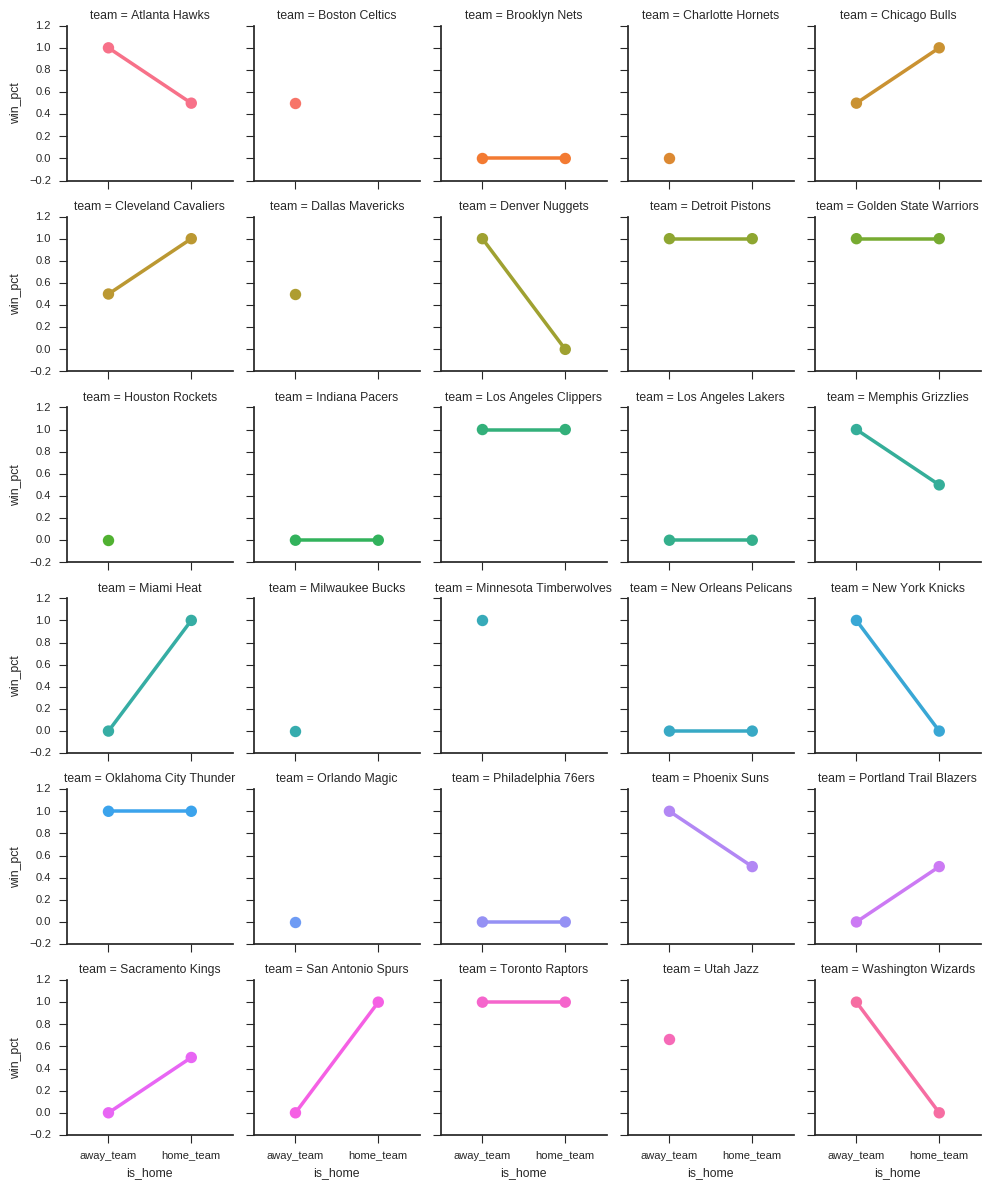

In [50]:
g = sns.FacetGrid(wins.reset_index(), col='team', hue='team', col_wrap=5, size=2)
g.map(sns.pointplot, 'is_home', 'win_pct')

In [142]:
win_percent = (
    # Use sum(games) / sum(games) instead of mean
    # since I don't know if teams play the same
    # number of games at home as away
    wins.groupby(level='team', as_index=True)
        .apply(lambda x: x.n_wins.sum() / x.n_games.sum())
)
win_percent.head()

team
Atlanta Hawks        0.666667
Boston Celtics       0.500000
Brooklyn Nets        0.000000
Charlotte Hornets    0.000000
Chicago Bulls        0.666667
dtype: float64

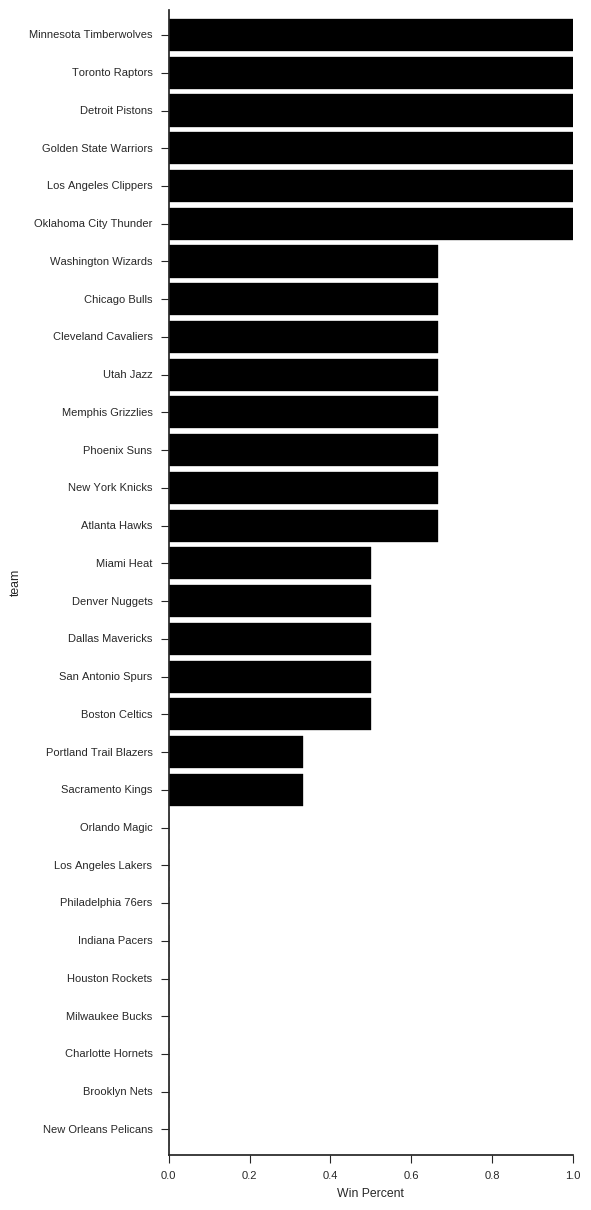

In [143]:
win_percent.sort_values().plot.barh(figsize=(6, 12), width=.85, color='k')
plt.tight_layout()
sns.despine()
plt.xlabel("Win Percent")

In [145]:
(wins.win_pct
    .unstack()
 )

is_home,away_team,home_team
team,,
Atlanta Hawks,1.000000,0.5
Boston Celtics,NaN,0.5
Brooklyn Nets,0.000000,0.0
Charlotte Hornets,0.000000,NaN
Chicago Bulls,0.500000,1.0
...,...,...
Sacramento Kings,0.000000,0.5
San Antonio Spurs,0.000000,1.0
Toronto Raptors,1.000000,1.0


In [148]:
(wins.win_pct
    .unstack()
    .assign(**{'Home Win % - Away %': lambda x: x.home_team - x.away_team,
               'Overall %': lambda x: (x.home_team + x.away_team) / 2})
     #.pipe((sns.regplot, 'data'), x='Overall %', y='Home Win % - Away %')
)

is_home,away_team,home_team,Home Win % - Away %,Overall %
team,,,,
Atlanta Hawks,1.000000,0.5,-0.5,0.75
Boston Celtics,NaN,0.5,NaN,NaN
Brooklyn Nets,0.000000,0.0,0.0,0.00
Charlotte Hornets,0.000000,NaN,NaN,NaN
Chicago Bulls,0.500000,1.0,0.5,0.75
...,...,...,...,...
Sacramento Kings,0.000000,0.5,0.5,0.25
San Antonio Spurs,0.000000,1.0,1.0,0.50
Toronto Raptors,1.000000,1.0,0.0,1.00


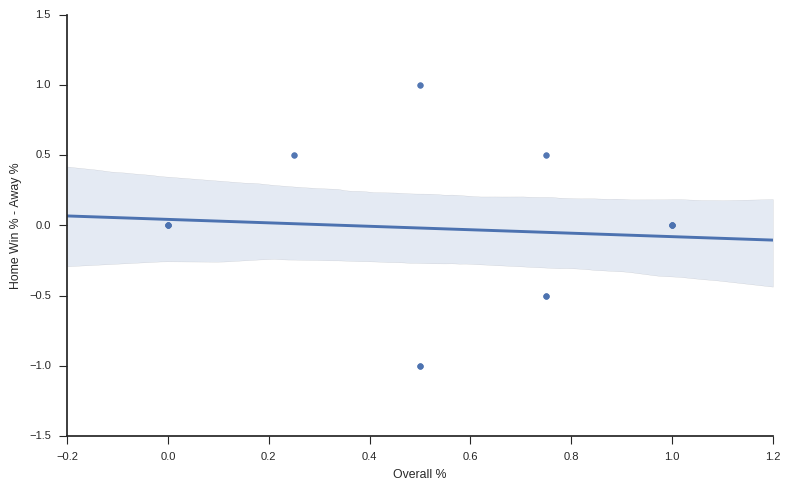

In [144]:
plt.figure(figsize=(8, 5))
(wins.win_pct
    .unstack()
    .assign(**{'Home Win % - Away %': lambda x: x.home_team - x.away_team,
               'Overall %': lambda x: (x.home_team + x.away_team) / 2})
     .pipe((sns.regplot, 'data'), x='Overall %', y='Home Win % - Away %')
)
sns.despine()
plt.tight_layout()

In [150]:
df.head()

,,away_team,away_points,home_team,home_points,away_rest,home_rest,home_win,rest_spread,away_strength,home_strength,point_diff,rest_diff
game_id,date,,,,,,,,,,,,
0,2015-10-27,Detroit Pistons,106,Atlanta Hawks,94,NaN,NaN,False,NaN,1.000000,0.666667,-12,NaN
1,2015-10-27,Cleveland Cavaliers,95,Chicago Bulls,97,NaN,NaN,True,NaN,0.666667,0.666667,2,NaN
2,2015-10-27,New Orleans Pelicans,95,Golden State Warriors,111,NaN,NaN,True,NaN,0.000000,1.000000,16,NaN
3,2015-10-28,Philadelphia 76ers,95,Boston Celtics,112,NaN,NaN,True,NaN,0.000000,0.500000,17,NaN
4,2015-10-28,Chicago Bulls,115,Brooklyn Nets,100,0.0,NaN,False,NaN,0.666667,0.000000,-15,NaN


In [149]:
df = df.assign(away_strength=df['away_team'].map(win_percent),
               home_strength=df['home_team'].map(win_percent),
               point_diff=df['home_points'] - df['away_points'],
               rest_diff=df['home_rest'] - df['away_rest'])
df.head()

,,away_team,away_points,home_team,home_points,away_rest,home_rest,home_win,rest_spread,away_strength,home_strength,point_diff,rest_diff
game_id,date,,,,,,,,,,,,
0,2015-10-27,Detroit Pistons,106,Atlanta Hawks,94,NaN,NaN,False,NaN,1.000000,0.666667,-12,NaN
1,2015-10-27,Cleveland Cavaliers,95,Chicago Bulls,97,NaN,NaN,True,NaN,0.666667,0.666667,2,NaN
2,2015-10-27,New Orleans Pelicans,95,Golden State Warriors,111,NaN,NaN,True,NaN,0.000000,1.000000,16,NaN
3,2015-10-28,Philadelphia 76ers,95,Boston Celtics,112,NaN,NaN,True,NaN,0.000000,0.500000,17,NaN
4,2015-10-28,Chicago Bulls,115,Brooklyn Nets,100,0.0,NaN,False,NaN,0.666667,0.000000,-15,NaN


In [151]:
import statsmodels.formula.api as sm

df['home_win'] = df.home_win.astype(int)  # for statsmodels

In [154]:
df[ ['home_win', 'home_strength', 'away_strength', 'home_rest', 'away_rest']]

,,home_win,home_strength,away_strength,home_rest,away_rest
game_id,date,,,,,
0,2015-10-27,0,0.666667,1.000000,NaN,NaN
1,2015-10-27,1,0.666667,0.666667,NaN,NaN
2,2015-10-27,1,1.000000,0.000000,NaN,NaN
3,2015-10-28,1,0.500000,0.000000,NaN,NaN
4,2015-10-28,0,0.000000,0.666667,NaN,0.0
...,...,...,...,...,...,...
33,2015-10-31,1,1.000000,0.333333,1.0,0.0
34,2015-10-31,1,0.666667,0.000000,1.0,0.0
35,2015-10-31,0,0.000000,1.000000,2.0,0.0


## Changed the logit regression below
####  as the data I have gives a perfect fit (so is not same as web page data)

In [159]:
mod = sm.logit('home_win ~ home_strength + away_strength', df)
res = mod.fit()
res.summary()

Optimization terminated successfully.
         Current function value: 0.107623
         Iterations 11


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:               home_win   No. Observations:                   38
Model:                          Logit   Df Residuals:                       35
Method:                           MLE   Df Model:                            2
Date:                Mon, 30 Oct 2017   Pseudo R-squ.:                  0.8435
Time:                        18:47:44   Log-Likelihood:                -4.0897
converged:                       True   LL-Null:                       -26.129
                                        LLR p-value:                 2.683e-10
=================================================================================
                    coef    std err          z      P>|z|      [95.0% Conf. Int.]
---------------------------------------------------------------------------------
Intercept        -1.5081      5.221     -0.289      0.773       -11.741     8.725
home_strength    14.2671     10.147      1.406      0.160        -5.620    34.154
away_strength   -14.1675      6.806     -2.082      0.037       -27.507    -0.828
=================================================================================

Possibly complete quasi-separation: A fraction 0.37 of observations can be
perfectly predicted. This might indicate that there is complete
quasi-separation. In this case some parameters will not be identified.
"""

## Add a column and use it as an independent variable in one line

In [160]:
(sm.Logit.from_formula('home_win ~ strength_diff + rest_spread',
                       df.assign(strength_diff=df.home_strength - df.away_strength))
    .fit().summary())

PerfectSeparationError: Perfect separation detected, results not available

In [161]:
mod = sm.Logit.from_formula('home_win ~ home_rest + away_rest', df)
res = mod.fit()
res.summary()

Optimization terminated successfully.
         Current function value: 0.679508
         Iterations 4


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:               home_win   No. Observations:                   21
Model:                          Logit   Df Residuals:                       18
Method:                           MLE   Df Model:                            2
Date:                Mon, 30 Oct 2017   Pseudo R-squ.:                0.004979
Time:                        18:50:45   Log-Likelihood:                -14.270
converged:                       True   LL-Null:                       -14.341
                                        LLR p-value:                    0.9311
==============================================================================
                 coef    std err          z      P>|z|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept     -0.1794      0.933     -0.192      0.847        -2.008     1.649
home_rest      0.1283      0.843      0.152      0.879        -1.524     1.780
away_rest     -0.2910      0.815     -0.357      0.721        -1.888     1.306
==============================================================================
"""